In [1]:
from pathinit import *

import jax
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
import jaxopt

from functools import partial

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

from jax.config import config
config.update("jax_enable_x64", True)

import scipy as sc
from scipy.optimize import minimize as sc_minimize
import scipy.stats as scs
import scipy.integrate as sc_integrate

#integration homemade
from CCquadInteg import *

import arviz as az
import seaborn as sns
import pandas  as pd

# Thème: Monte Carlo sampling.
en lien avec la note `JaxTutos/note-MCMC-Numpyro-Oct21.pdf` (French)

# Le cas du calcul d'une intégrale 1D

In [2]:
def prob(x, norm=1):
    return ((8/0.5)*jnp.exp(-0.5*(x/0.5)**2)+
                (2/0.1)*jnp.exp(-0.5*((x-1.5)/0.1)**2))/norm 

In [3]:
def phi(x):
    return x**2/8

# la librairie Scipy fournit une intégration numérique

In [4]:
Z = sc_integrate.quad(lambda x: prob(x),-3, 3)
Integ_true,err= sc_integrate.quad(lambda x: prob(x,norm=Z[0])*phi(x),-3, 3)
print("<phi>_true =",Integ_true,"+/-",err)

<phi>_true = 0.08149999825655681 +/- 4.063804085486462e-14


In [5]:
err/Integ_true

4.98626278824432e-13

### Au passage on peut utiliser le code d'intégration à base de la quadrature de Clenshaw-Curtis (`CCquadInteg.py`)

## Maintenant calculons la moyenne de $\phi(x)$ quand $x\sim p(x)$:
$$
\Large
E[\phi] = \int \phi(x)\ p(x) dx
$$

In [6]:
@jit
def f(x,norm=1):
    return phi(x)*prob(x,norm)

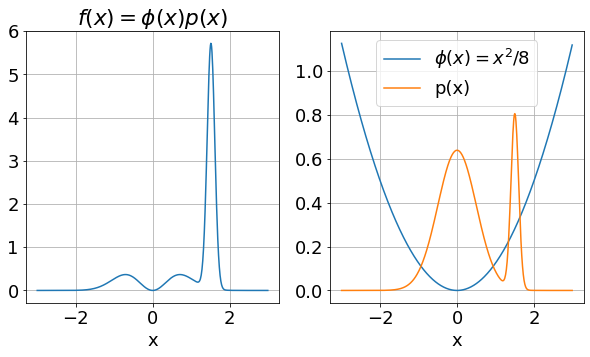

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
x = np.arange(-3,3,0.01)
axs[0].plot(x,f(x))
axs[0].set_xlabel("x")
axs[0].set_title("$f(x)=\phi(x) p(x)$")
axs[0].grid();
axs[1].plot(x,phi(x),label="$\phi(x)=x^2/8$")
axs[1].plot(x,prob(x,norm=Z[0]),label="p(x)")
axs[1].set_xlabel("x")
axs[1].legend()
axs[1].grid();

# Methode "moyenne" 

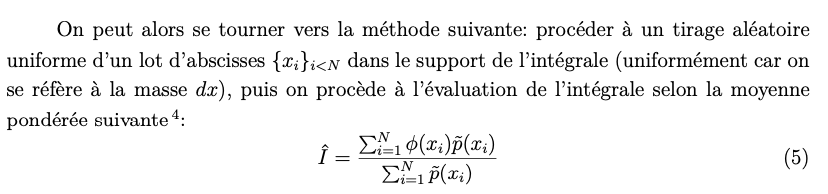

In [8]:
@partial(jit, static_argnums=(0,1))
def Integ0(N, f, subkey):
    xi = jax.random.uniform(subkey, (N,), minval=-3,maxval=3)
    Z_hat = jnp.sum(prob(xi))
    return jnp.sum(f(xi))/Z_hat

In [9]:
key = jax.random.PRNGKey(42)
Ns = [1000,10000,100000,1000000]
for n in Ns: 
    key, subkey = jax.random.split(key)
    I0 = Integ0(n,f,subkey)
    print(n,(I0-Integ_true)/Integ_true)

1000 -0.08168756632933925
10000 -0.014392879092519255
100000 0.005641294645926664
1000000 -0.002412695248168521


In [10]:
key = jax.random.PRNGKey(20)
Ns = np.int32(np.logspace(3,7,50))
info =[]
for n in Ns: 
    key, subkey = jax.random.split(key)
    I0 =  Integ0(n,f,subkey)
    info.append(I0)

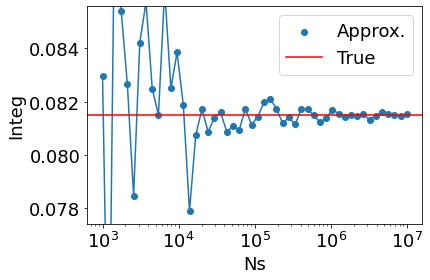

In [11]:
plt.scatter(Ns,np.array(info),label='Approx.')
plt.plot(Ns,np.array(info))
plt.axhline(y=Integ_true, color='r', linestyle='-',label='True')
plt.xscale('log')
plt.xlabel('Ns')
plt.ylabel('Integ')
plt.ylim([Integ_true*0.95,Integ_true*1.05])
plt.legend()
plt.show()

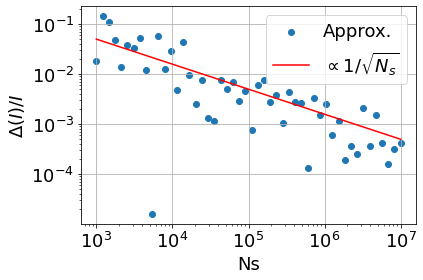

In [12]:
plt.scatter(Ns,np.abs(np.array(info)-Integ_true)/Integ_true,label='Approx.')
#plt.plot(Ns,np.abs(np.array(info)-Integ_true)/Integ_true)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ns')
plt.ylabel('$\Delta(I)/I$')
plt.plot(Ns,0.035*np.sqrt(2e3/Ns),label='$\propto 1/\sqrt{N_s}$',c='r')
plt.grid()
plt.legend()
plt.show()

## Notez bien la dépendance $1/\sqrt{N}$

In [13]:
print(f"Ns       err. relat.")
for n in range(3,7):
    cut = (10**n<=Ns) & (Ns<10**(n+1))
    print(f"{np.mean(Ns[cut]):7.0f}\
 {(np.mean(np.array(info)[cut])-Integ_true)/Integ_true:15.6e}")

Ns       err. relat.
   3910    1.594260e-02
  39628   -6.282093e-03
 378099    5.583642e-04
3607432    9.038853e-05


## notez que l'on peut également utliser la quadrature de Clenshaw-Curtis

In [14]:
quad = ClenshawCurtisQuad(100) # 200pts
Z = quadIntegral(lambda x: prob(x), -3,3, quad)
Integ_cc=quadIntegral(lambda x: prob(x,norm=Z)*phi(x),-3,3, quad)
print("Diff relat. avec scipy: ",(Integ_cc-Integ_true)/Integ_true)

Diff relat. avec scipy:  -5.108388259394091e-16


### Le problème qui se pose à nous c'est qu'en grande dimension il n'existe pas de quadrature générale sauf le produit cartésien de quadrature 1D à $n$-points,  dont le nbre de points croit comme $n^d$. ex. $n=10$ et $d=20$, nombre colossal (ie. $4 10^{19}$ positions diff. du Rubik's cube, $10^24$ atomes dans l'Univers "visible".)  On va donc se tourner vers des techniques Monte Carlo.

# Importance Sampling

L'idée est de générer des échantillons aléatroires selon une distribution $q(x)$ laquelle est une approximation de $p(x)$ (on note avec un $\tilde{}$ la distribution non-normalisée)

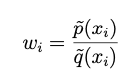
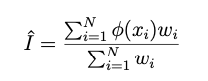
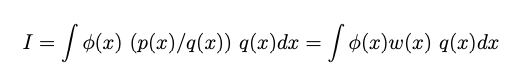

Le choix de $q(x)$ va conditionner la performance de cet algorithme.

## Ci-dessous 2 types d'approxiamtions à base de gaussiennes

In [15]:
scale_0 = 3
def qapp0(x):
    return 90*jax.scipy.stats.norm.pdf(x,scale=scale_0)

In [16]:
scale_1 = 0.5
mean_1  = 1.5
def qapp(x):
    return 20*(jax.scipy.stats.norm.pdf(x,scale=scale_1)+\
            jax.scipy.stats.norm.pdf(x-mean_1,scale=scale_1))

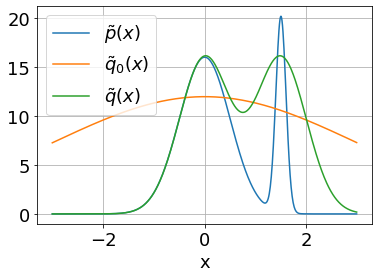

In [17]:
x = np.arange(-3,3,0.01)
plt.plot(x,prob(x), label=r"$\tilde{p}(x)$")
plt.plot(x,qapp0(x), label=r'$\tilde{q}_0(x)$')
plt.plot(x,qapp(x), label=r'$\tilde{q}(x)$')
plt.grid()
plt.legend()
plt.xlabel("x");

Si la génération de nombre aléatoire avec 1 gaussienne directement implémentée dans les librairy, voici une génération simple d'une distribution somme de 2 gaussiennes.

In [18]:
key, subkey1,subkey2  = jax.random.split(jax.random.PRNGKey(42),3)
xs1 = jax.random.normal(subkey1, (10000,))*scale_1
xs2 = jax.random.normal(subkey2, (10000,))*scale_1+mean_1
xs  = jnp.concatenate([xs1,xs2])

In [19]:
quad = ClenshawCurtisQuad(100)
Zq = quadIntegral(lambda x: qapp(x),-5, 5, quad) 

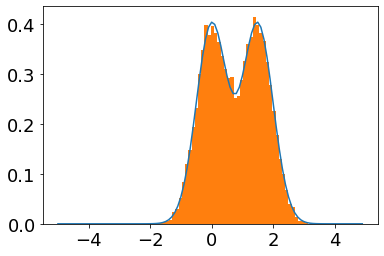

In [20]:
xi = np.arange(-5,5,0.1)
plt.plot(xi,qapp(xi)/Zq)
plt.hist(np.array(xs),bins=50,density=True); 
# hist n'aime pas les devic array de Jax/Lax mais la conversion en np.ndarray est immediate

In [21]:
@partial(jit, static_argnums=1)
def importance_sampling(key,N):
    key, subkey = jax.random.split(key)
    xs1= jax.random.normal(subkey, (N//2,))*scale_1
    xs2= jax.random.normal(subkey, (N//2,))*scale_1 + mean_1
    x_Qrnd=jnp.concatenate([xs1,xs2])
    w = prob(x_Qrnd)/qapp(x_Qrnd)
    norm = jnp.sum(w)
    phi_samples=phi(x_Qrnd)
    integ = jnp.dot(w/norm,phi_samples)
    return integ,w, key

@partial(jit, static_argnums=1)
def importance_sampling_0(key,N):
    key, subkey = jax.random.split(key)
    x_Qrnd=jax.random.normal(subkey, (N,))*scale_0
    w = prob(x_Qrnd)/qapp0(x_Qrnd)
    norm = jnp.sum(w)
    phi_samples=phi(x_Qrnd)
    integ = jnp.dot(w/norm,phi_samples)
    return integ,w, key

In [22]:
Integ_is,Ws0,_= importance_sampling_0(key,100000)
print(f"$I_{{is}}^0$ = {Integ_is:.6e};  \trelat. err ={np.abs(Integ_is-Integ_true)/Integ_true:.6e}")

Integ_is,Ws,_= importance_sampling(key,100000)
print(f"$I_{{is}}$ = {Integ_is:.6e};  \trelat. err ={np.abs(Integ_is-Integ_true)/Integ_true:.6e}")

$I_{is}^0$ = 8.142562e-02;  	relat. err =9.125766e-04
$I_{is}$ = 8.159547e-02;  	relat. err =1.171418e-03


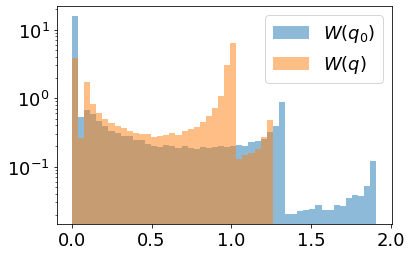

In [23]:
_,bins,_=plt.hist(np.array(Ws0),bins=50,alpha=0.5,density=True,label='$W(q_0)$');
plt.hist(np.array(Ws),bins=bins,alpha=0.5,density=True,label='$W(q)$');
plt.yscale('log')
plt.legend();

In [24]:
key = jax.random.PRNGKey(20)
Ns = np.int32(np.logspace(3,7,20))
infoI1_0 =[]
infoI1 =[]
for n in Ns: 
    I1_0,_,key =  importance_sampling_0(key,n)
    I1,_,key =  importance_sampling(key,n)
    infoI1_0.append(I1_0)
    infoI1.append(I1)

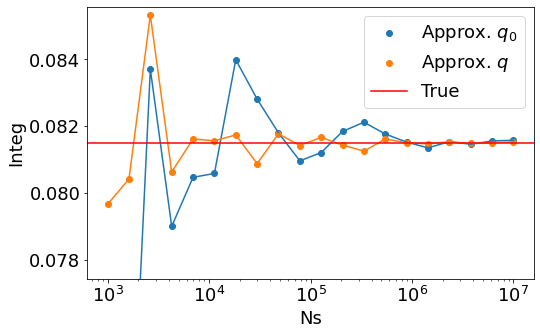

In [25]:
fig,_=plt.subplots(figsize=(8,5))
plt.scatter(Ns,np.array(infoI1_0),label='Approx. $q_0$')
plt.plot(Ns,np.array(infoI1_0))
plt.scatter(Ns,np.array(infoI1),label='Approx. $q$')
plt.plot(Ns,np.array(infoI1))
plt.axhline(y=Integ_true, color='r', linestyle='-',label='True')
plt.xscale('log')
plt.xlabel('Ns')
plt.ylabel('Integ')
plt.ylim([Integ_true*0.95,Integ_true*1.05])
plt.legend()
plt.show()

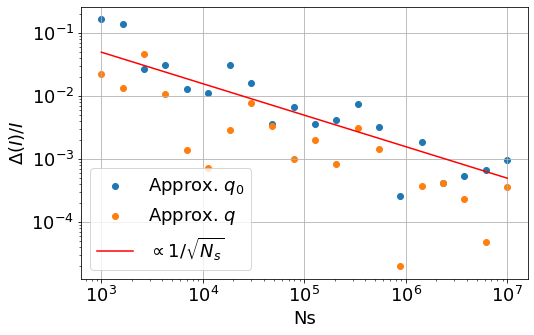

In [26]:
fig,_=plt.subplots(figsize=(8,5))
plt.scatter(Ns,np.abs(np.array(infoI1_0)-Integ_true)/Integ_true,label='Approx. $q_0$')
plt.scatter(Ns,np.abs(np.array(infoI1)-Integ_true)/Integ_true,label='Approx. $q$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ns')
plt.ylabel('$\Delta(I)/I$')
plt.plot(Ns,0.035*np.sqrt(2e3/Ns),label='$\propto 1/\sqrt{N_s}$',c='r')
plt.grid()
plt.legend()
plt.show()

In [27]:
print(f"Ns       err. relat. q_0   err. relat. q")
for n in range(3,7):
    cut = (10**n<=Ns) & (Ns<10**(n+1))
    print(f"{np.mean(Ns[cut]):7.0f}\
 {(np.mean(np.array(infoI1_0)[cut])-Integ_true)/Integ_true:15.6e}\
  {(np.mean(np.array(infoI1)[cut])-Integ_true)/Integ_true:15.6e}"
         )

Ns       err. relat. q_0   err. relat. q
   3298   -6.398933e-02     3.354881e-04
  37237    6.475739e-03    -3.460517e-04
 420349    2.333749e-03    -9.331659e-05
3431336   -3.256506e-04    -3.602916e-05


## **moralité**: plus on a une approximation $q(x)$ "bonne" de $p(x)$ meilleure est le calcul de l'intégrale, c'est-à-dire le sampling de $p(x)$. Cela se traduit en fait sur la distribution des poids qui au mieux doit se concentrer autour de $1$. Mais cela devient très improbable en grande dimension. Voir l'exo suivant.

# En dimension N>1

## Soit la loi uniforme dans une boule de rayon $R$ en dimension $d$

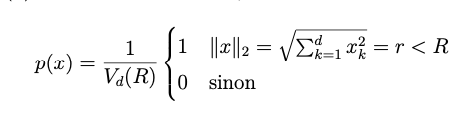

## on veut calculer par *importance samping* l'intégrale suivante 
$$
\Large
I(d) = \int r^2 p(x) dx^d = R^2 \frac{d}{d+1}
$$



## Exo: coder la fonction $p(x)$
```python
@jit
def prob_nD(x,R=1):
    res = ...
    return res
```
*hint*: rappelez vous que l'on n'a pas besoin de connaître la normalisation, ca simplifie beaucoup :)

In [28]:
@jit
def prob_nD(x,R=1):
    r  = jnp.linalg.norm(x,axis=1)
    return jnp.where(r<R,1,0)

## On va se servir comme approximation de la loi normale centrée en dimension $d$
$$
\Large
q(x) = \mathcal{N}_d(0,\sigma^2) = \frac{e^{-x^2/(2\sigma^2)}}{(2\pi\sigma^2)^{d/2}}
$$

In [29]:
@jit
def qapp_nD(x,s=1):
    dim = x.shape[1]
    return jax.scipy.stats.multivariate_normal.pdf(x,np.zeros(dim), s**2*np.identity(dim))

Où sont localisés les points tirées selon une loi gaussienne en dimension $d$?
$$
\Large
\langle r \rangle =  \langle \sqrt{\|x\|^2} \rangle = \sigma \sqrt{d}; \qquad \sigma_r = \frac{\sigma}{\sqrt{2}}
$$

In [30]:
key = jax.random.PRNGKey(0)
N=10_000
dims = jnp.array([10,20,50,100,200,500,1000])
s=1
info1 = []
info2 = []
for dim in dims:
    key, subkey = jax.random.split(key)
    data = jax.random.multivariate_normal(subkey,
                                        np.zeros(dim),
                                        s**2*np.identity(dim),
                                        (N,))
    r = jnp.linalg.norm(data,axis=1)
    info1.append(jnp.mean(r))
    info2.append(jnp.std(r))

2022-04-17 11:38:37.023140: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:212] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.3 = f64[10000,10]{1,0} custom-call(f64[10000,10]{1,0} %multiply.313, f64[10,10]{0,1} %select.49, f64[10000,10]{1,0} %broadcast.322), custom_call_target="__cublas$gemm", metadata={op_name="jit(_multivariate_normal)/jit(main)/add" source_file="/tmp/ipykernel_175/3849636871.py" source_line=9}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":1,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"100000\",\"rhs_stride\":\"100\"}" failed. Falling back to default algorithm.  Per-algorithm errors:
2022-04-17 11:38:38.333175: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorit

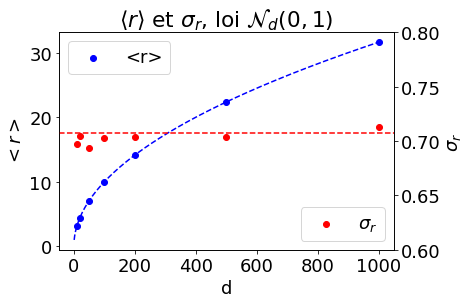

In [31]:
fig, ax = plt.subplots()
axes = [ax, ax.twinx()]
axes[0].scatter(dims,info1,c='b',label="<r>");
xi = np.arange(1,1000,0.1)
axes[0].plot(xi,np.sqrt(xi),c='b',ls="--")
axes[0].set_xlabel("d")
axes[0].set_ylabel("$<r>$")
axes[1].scatter(dims,info2,c='r',label="$\sigma_r$");
axes[1].axhline(y=1/np.sqrt(2), color='r', linestyle='--')
axes[1].set_ylim([0.6,0.8])
axes[1].set_ylabel("$\sigma_r$")
plt.title(r"$\langle r \rangle$ et $\sigma_r$, loi $\mathcal{N}_d(0,1)$");
axes[0].legend(loc='upper left');
axes[1].legend(loc="lower right");

## Donc en dimension $d$ les points générés par une gaussienne centrée, contrairement à l'intuition, se concentre non pas autour de l'origine mais sur une coquille de rayon $\langle r\rangle = \sigma d^{1/2}$ dont l'épaisseur est une constante $\sigma_r$. Donc, pour que les poids $p(x_i)/q(x_i)$ ne soient pas nuls ou infinis il faut que $\langle r\rangle\leq R$ c'est-à-dire $\sigma\leq R/\sqrt{d}$ 

In [32]:
@jit
def phi_nD(x):
    r  = jnp.linalg.norm(x,axis=1)
    return r*r

In [33]:
@partial(jit, static_argnums=(1,2))
def importance_sampling_nD(key,N,dim=2,R=1,s=1):
    key, subkey = jax.random.split(key)
    x_Qrnd = jax.random.multivariate_normal(subkey,
                                            np.zeros(dim),
                                            s**2*np.identity(dim),
                                            (N,))
    
    w = prob_nD(x_Qrnd,R)/qapp_nD(x_Qrnd,s)
    norm = jnp.sum(w)
    w /= norm
    phi_samples=phi_nD(x_Qrnd)
    integ = jnp.dot(w,phi_samples)
    return key,integ,w

In [34]:
def integ_true_nD(dim,R=1):
    return R**2*dim/(dim+2)

In [35]:
key = jax.random.PRNGKey(50)
Ns = 100_000
dim = 400
R = 1
facteur=1.0
sigma =  facteur  * R/np.sqrt(dim)
_,integ_is,w = importance_sampling_nD(key,Ns,dim=dim,R=R,s=sigma)
I_true =  integ_true_nD(dim,R)
print(f"Integ= {integ_is:.6}, True={I_true:.6}, err relat.={(integ_is-I_true)/I_true:.2e}" )
w_max = jnp.max(w)
w_med = jnp.median(w)
print(f"w max: {w_max:.6e}, med: {w_med:.6e}, max/med: {w_max/w_med:.6e}")

2022-04-17 11:38:55.710903: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:212] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[100000,400]{0,1} custom-call(f64[100000,400]{1,0} %multiply.339, f64[400,400]{0,1} %select.51), custom_call_target="__cublas$gemm", metadata={op_name="jit(importance_sampling_nD)/jit(main)/jit(_einsum)/jit(jit__einsum)/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_175/317995946.py" source_line=4}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"40000000\",\"rhs_stride\":\"160000\"}" failed. Falling back to default algorithm.  Per-algorithm errors:


Integ= 0.994978, True=0.995025, err relat.=-4.74e-05
w max: 3.594770e-04, med: 2.448502e-18, max/med: 1.468151e+14


## Exo: changer le facteur pour  {0.8,1.17561336}

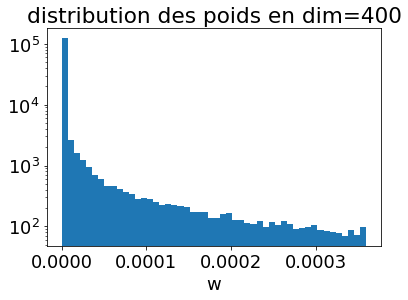

In [36]:
plt.hist(np.array(w),bins=50,density=True);
plt.yscale('log')
plt.title(f"distribution des poids en dim={dim}")
plt.xlabel("w");

## la distribution des poids est tres piquée à petit $w$ et le rapport $w_{max}/w_{med}$ explose

In [37]:
def test(dim):
    key = jax.random.PRNGKey(0)
    Ns = 10_000
    R = 1
    sigma = R/jnp.sqrt(dim)
    _,integ,w = importance_sampling_nD(key,Ns,dim=dim,R=R,s=sigma)
    w_max = jnp.max(w)
    w_med = jnp.median(w)
    return integ,w_max/w_med

In [38]:
dims = np.array([1,2,5,10,20,30,40,50,100,200,300,400])

In [39]:
info = []
for d in dims:
    _,val = test(d)
    info.append(val)

2022-04-17 11:39:08.926372: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:212] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[10000,2]{0,1} custom-call(f64[10000,2]{1,0} %multiply.339, f64[2,2]{0,1} %select.51), custom_call_target="__cublas$gemm", metadata={op_name="jit(importance_sampling_nD)/jit(main)/jit(_einsum)/jit(jit__einsum)/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_175/317995946.py" source_line=4}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"20000\",\"rhs_stride\":\"4\"}" failed. Falling back to default algorithm.  Per-algorithm errors:
2022-04-17 11:39:0

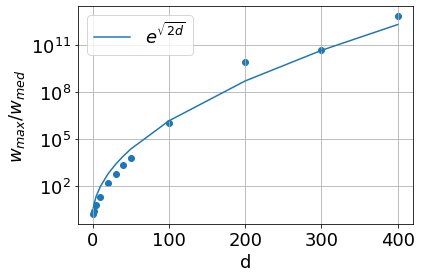

In [40]:
plt.scatter(dims,info)
plt.yscale('log')
plt.plot(dims,np.exp(np.sqrt(2*dims)),label="$e^{\sqrt{2d}}$")
plt.xlabel("d")
plt.ylabel("$w_{max}/w_{med}$")
plt.grid()
plt.legend()
plt.show()

# le calcul de l'intégrale est déterminée par une distribution de poids qui n'a rien de centrée sur $1$ et devient très sensible aux poids dans la  queue de distribution.

# Metropolis-Hastings method
(C. Metropolis (1915-99) et Wilfred Hastings (1930-2016))

## La méthode date des années 1950-70. Dans l'Importance Sampling $q(x)$ est choisie une fois pour toute. **M-H va générer des échantillons (constituant une chaine de Markov) où $q(x)$ va être adaptée à chaque titage**.

Pour générer un échantillon à l'étape $i$, noté $x_i$:
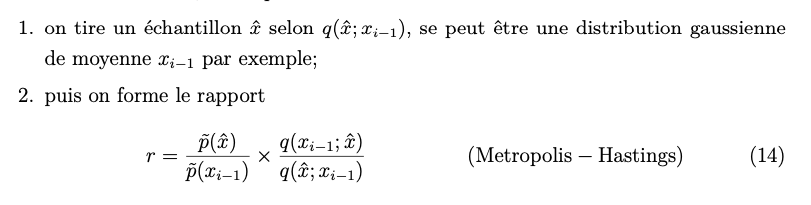

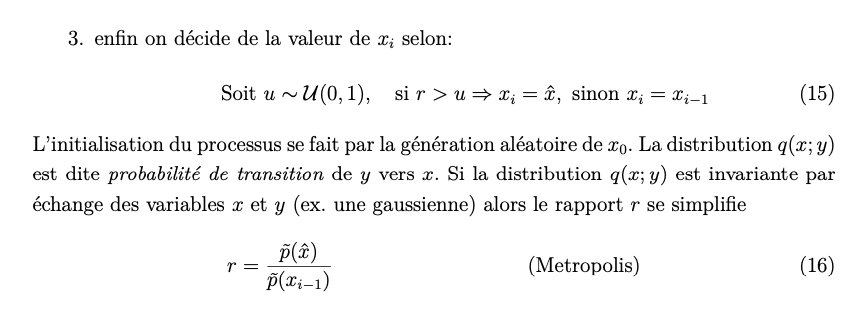


## Simple cas en 1D, multi-chaines (Numpy)

In [41]:
class MixtureModel(scs.rv_continuous):
    def __init__(self, submodels, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels
        weights   = np.array(weights)
        norm = np.sum(weights)
        self.weights = weights/norm
        self.num_distr = len(submodels)
        #print(self.num_distr, self.weights,self.submodels)
        

    def _pdf(self, x):
        pdf = 0.
        for i, submodel in enumerate(self.submodels):
            pdf += self.weights[i]*submodel.pdf(x)
            
        return pdf

    # Random generation to compare with Metropolis sampling
    def rvs(self, sample_size):
        random_idx = np.random.choice(np.arange(self.num_distr), size=(sample_size,), p=self.weights)
        submodel_samples = [submodel.rvs(size=sample_size) for submodel in self.submodels]
        print(np.array(submodel_samples).shape)
        rvs = np.choose(random_idx, submodel_samples)
        return rvs

In [42]:
# somme de 2 gaussiennes
mixture_gaussian_model = MixtureModel([scs.norm(loc=0, scale=0.5), 
                                       scs.norm(loc=1.5, scale=0.2)],
                                      [8,2])

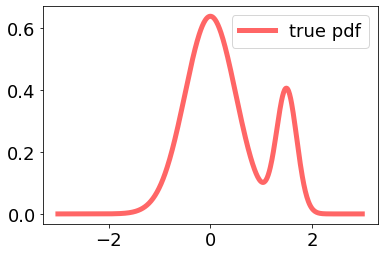

In [43]:
x_axis = np.arange(-3, 3, 0.01)
plt.plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.legend();

In [44]:
def phi(x):
    return x**2

## L'idée est d'utiliser la méthode M-H pour générer des échantillons selon $p(x)$ (mixture of gaussian) est de calculer la moyenne de $\phi(x)$.

In [45]:
def MHSampling_v2p(proba,Ns=100_000,Nchain=10,scale=0.1, forget=25_000):
    # Ns nbre de samples per chain
    samples = []
    # forget a fixed number of samples for each chain
    Ns = Ns + forget
    current = scs.uniform.rvs(loc=-3,scale=6, size=(Nchain,))
    for i in range(Ns):
        samples.append(current.copy())
        #proposal distrib. uniforme in [current-scale,current+scale]
        proposal = scs.uniform.rvs(loc=current-scale,scale=2*scale, size=(Nchain,))
        # proposal distrib is symetric: q(x_c,x_p)=q(x_c-x_p)=q(x_p,x_c)
        r = proba(proposal)/proba(current)  
        u = scs.uniform.rvs(size=(Nchain,))
        mask = r>u #accept proposal
        current[mask] = proposal[mask]

    #return all chains with the first "forget" samples rejected
    samples = np.array(samples).T
    return samples[:,forget:]

# Warning: La commande suivante est un peu longue... ~ 2'30 

In [46]:
spls = MHSampling_v2p(lambda x: mixture_gaussian_model.pdf(x),
                            Ns=100_000, Nchain=100, forget=25_000, scale=0.1
                           )

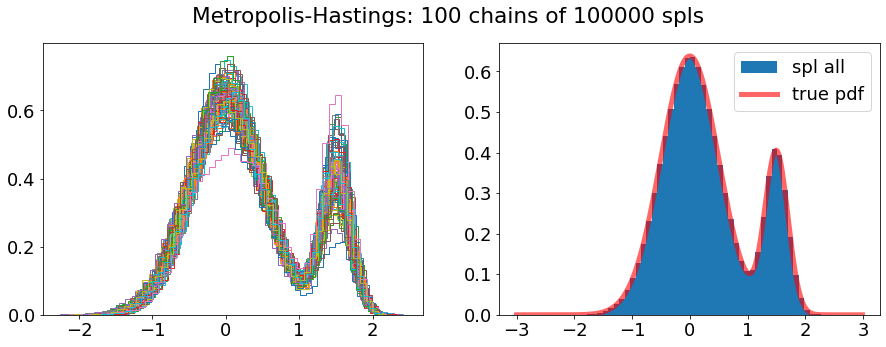

In [47]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(spls.shape[0]):
    axs[0].hist(spls[i],bins=50, density=True, histtype='step',label=f"spl [{i}]");
#axs[0].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
#axs[0].legend(loc='upper right')
#
axs[1].hist(spls.flatten(),bins=50, density=True,label=f"spl all");
x_axis = np.arange(-3, 3, 0.01)
axs[1].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
axs[1].legend()
fig.suptitle(f"Metropolis-Hastings: {spls.shape[0]} chains of {spls.shape[1]} spls")

plt.show()

In [48]:
spl_all= spls.flatten()
phi_spl = phi(spl_all)
Integ_M = np.mean(phi_spl)

In [49]:
print(f"Integ ({spl_all.shape[0]:.0e} spl): {Integ_M:.6e}")

Integ (1e+07 spl): 6.669508e-01


In [50]:
Integ_true,err= sc_integrate.quad(lambda x: phi(x)*mixture_gaussian_model.pdf(x),-3, 3)

In [51]:
Integ_true

0.6579999850231879

In [52]:
print(f"Erreur relative : {(Integ_M-Integ_true)/Integ_true:.4}")

Erreur relative : 0.0136


## Pourquoi a-t-on un si mauvais résultat? alors que l'on a tiré $10^7$ échantillons et donc on s'attend à une approximation $O(1/\sqrt{10^7})=O(3\ 10^{-4})$

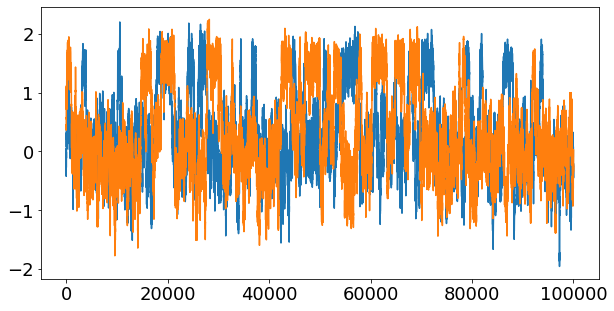

In [53]:
fig = plt.figure(figsize=(10,5))
plt.plot(spls[0])
plt.plot(spls[1])

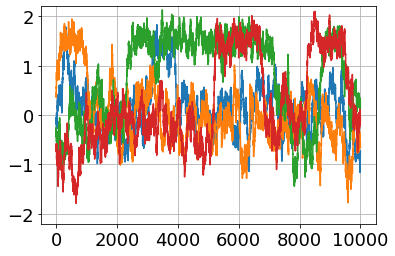

In [112]:
plt.plot(spls[0][:10_000])
plt.plot(spls[1][:10_000])
plt.plot(spls[2][:10_000])
plt.plot(spls[3][:10_000])
plt.ylim([-2.2,2.2])
plt.grid();

## Pour explorer un range $L$ avec un step de $\varepsilon=0.1$ il faut au un temps de l'ordre de $T=O((L/\varepsilon)^2)$. C'est la loi de marche àléatoire, qui est très lente... Or, augmenter $\varepsilon$ nous ferait rater le pic secondaire...

## Exo: changer la valeur de scale=0.1

## Ceci étant la question qu'il faut se poser c'est de savoir quel est le nombre effectif d'échantillons indépendants que l'on a collecté?

In [54]:
import arviz as az

In [58]:
print(f"iid sample size : 1 chaine {az.ess(spls[0]):.2e}, ttes les chaines {az.ess(spl_all):.2e}")

iid sample size : 1 chaine 1.20e+02, ttes les chaines 1.08e+04


## Ainsi avec toutes les chaines on a seulement une approximation $O(10^{-2})$ ce qu'en effet nous avons obtenu. L'efficacité de sampling (iid) est de l'ordre de $0.1\%$, et cela est typique des librairies qui utilisent la méthode de M-H. Cela oblige à générer des chaines très longues en parallèle pour pouvoir obtenir un lot suffisament important pour obtenir des approximations de paramètres satisfaisantes.  Nous allons voir qu'il y a des méthodes plus efficaces.

## Version avec les logprob et implementee en Jax. Ici juste histoire de voir que JAX/JIT va plus vite mais ne change pas le problème de M-H.

Vous pouvez ouvrir une fenêtre Terminal (File->New->Terminal) et taper

> watch nvidia-smi

vous verrez alors la charge sur le GPU. 

Pour en sortir, `crtl C`.

In [59]:
class MixtureModel_jax():
    def __init__(self, locs, scales, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loc = jnp.array([locs]).T
        self.scale = jnp.array([scales]).T
        self.weights = jnp.array([weights]).T
        norm = jnp.sum(self.weights)
        self.weights = self.weights/norm

        self.num_distr = len(locs)

    def pdf(self, x):
        probs = jax.scipy.stats.norm.pdf(x,loc=self.loc, scale=self.scale)
        return jnp.dot(self.weights.T,probs).squeeze()
        
    def logpdf(self, x):
        log_probs = jax.scipy.stats.norm.logpdf(x,loc=self.loc, scale=self.scale)
        return jax.scipy.special.logsumexp(jnp.log(self.weights) + log_probs, axis=0)

In [60]:
mixture_gaussian_model = MixtureModel_jax([0,1.5],[0.5,0.1],[8,2])

In [ ]:
@partial(jax.jit, static_argnums=(1,))
def jax_metropolis_kernel(rng_key, logpdf, position, log_prob):
    key, subkey = jax.random.split(rng_key)
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
  
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
      Key for the pseudo random number generator.
    logpdf: function
      Returns the log-probability of the model given a position.
    position: np.ndarray, shape (n_dims,)
      The starting position.
    log_prob: float
      The log probability at the starting position.

    Returns
    -------
    Tuple
        The next positions of the chains along with their log probability.
    """
    move_proposals = jax.random.normal(key, shape=position.shape) * 0.1
    proposal = position + move_proposals
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob

@partial(jax.jit, static_argnums=(1, 2))
def jax_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
        Key for the pseudo random number generator.
    n_samples: int
        Number of samples to generate per chain.
    logpdf: function
      Returns the log-probability of the model given a position.
    inital_position: np.ndarray (n_dims, n_chains)
      The starting position.
    Returns
    -------
    (n_samples, n_dim)
    """
    def mh_update(i, state):
        key, positions, log_prob = state
        _, key = jax.random.split(key)
        new_position, new_log_prob = jax_metropolis_kernel(key, 
                                                           logpdf, 
                                                           positions[i-1], 
                                                           log_prob)
        positions=positions.at[i].set(new_position)
        return (key, positions, new_log_prob)


    logp = logpdf(initial_position)
    # all positions structure should be set before lax.fori_loop
    
    all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call
    
    initial_state = (rng_key,all_positions, logp)
    rng_key, all_positions, log_prob = jax.lax.fori_loop(1, n_samples, 
                                                 mh_update, 
                                                 initial_state)
    
    
    return all_positions

## ici on a 10x plus de statistique en 15sec

In [62]:
n_dim = 1
n_forget = 25_000
n_samples = 100_000 + n_forget
n_chains = 1_000

rng_key = jax.random.PRNGKey(42)

rng_keys = jax.random.split(rng_key, n_chains)
initial_position = jnp.zeros((n_dim, n_chains))

run_mcmc = vmap(jax_metropolis_sampler, 
                    in_axes=(0, None, None, 1),
                    out_axes=0)
all_positions = run_mcmc(rng_keys, n_samples, 
                     lambda x: mixture_gaussian_model.logpdf(x), 
                     initial_position)

all_positions = all_positions.squeeze()

all_positions=np.asarray(all_positions[:,n_forget:])

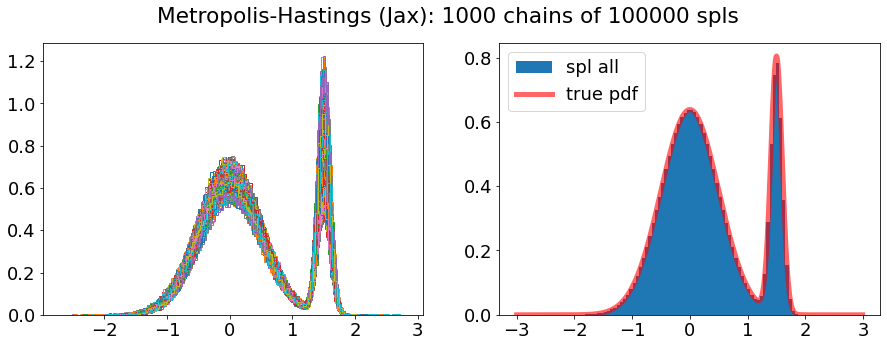

In [63]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(all_positions.shape[0]):
    axs[0].hist(all_positions[i],bins=100, density=True, histtype='step',label=f"spl [{i}]");
#axs[0].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
#axs[0].legend(loc='upper right')
#
axs[1].hist(all_positions.flatten(),bins=100, density=True,label=f"spl all");
x_axis = np.arange(-3, 3, 0.01)
axs[1].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
axs[1].legend()
fig.suptitle(f"Metropolis-Hastings (Jax): {all_positions.shape[0]} chains of {all_positions.shape[1]} spls")

plt.show()

## Exo: à vous de calculer l'intégrale sur $\phi(x)$ et l'efficacité de sampling...

# Au lieu de calculer un intégrale passons à l'estimation de parametres en dimension 3.

In [87]:
sample_size = 5_000
sigma_e = 1.5             # true value of parameter error sigma
random_num_generator = np.random.RandomState(0)
xi = 10.0 * random_num_generator.rand(sample_size)
e = random_num_generator.normal(0, sigma_e, sample_size)
yi = 1.0 + 2.0 * xi +  e          # a = 1.0; b = 2.0; y = a + b*x

In [88]:
def lik(parameters, X, Y):
    m = parameters[1]
    b = parameters[0]
    sigma = parameters[2]
    y_exp = m * X + b
    L = len(X)/2 * np.log(2 * np.pi * sigma ** 2) \
         + 1/(2 * sigma ** 2) * sum((Y - y_exp) ** 2)
    return L

In [89]:

lik_model = sc_minimize(lik, np.array([1,1,1]), args=(xi,yi), method='L-BFGS-B')
print("Parametres estimés par Scipy Minimize:", lik_model['x'])

Parametres estimés par Scipy Minimize: [0.98725158 1.99939789 1.47958158]


In [90]:
mini=lik_model['x']
df_mini = pd.DataFrame(mini[np.newaxis,:],columns=["bias","slope","sigma"])
df_mini["chain"]="Min Scipy"

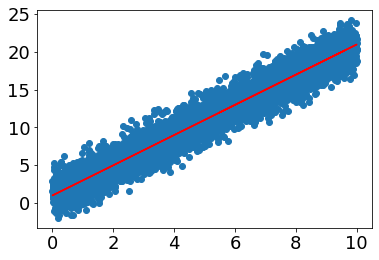

In [91]:
plt.scatter(xi,yi)
plt.plot(xi, lik_model['x'][1] * xi + lik_model['x'][0],c='r')
plt.show()

In [92]:
def jax_metropolis_kernel(rng_key, logpdf, position, log_prob):
    key, subkey = jax.random.split(rng_key)
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
    """
    move_proposals = jax.random.normal(key,  shape=position.shape)*0.1
        
    proposal = position + move_proposals
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob

def jax_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    """
    def mh_update(i, state):
        key, positions, log_prob = state
        _, key = jax.random.split(key)
                
        new_position, new_log_prob = jax_metropolis_kernel(key, 
                                                           logpdf, 
                                                           positions[i-1], 
                                                           log_prob)
                
        
        positions=positions.at[i].set(new_position)
        return (key, positions, new_log_prob)

    #Initialisation
    keys = jax.random.split(rng_key,num=4)
    all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call    ?
    all_positions=all_positions.at[0,0].set(jax.random.normal(keys[0])+1.)
    all_positions=all_positions.at[0,1].set(jax.random.normal(keys[1])+2.)
    all_positions=all_positions.at[0,2].set(jax.random.uniform(keys[2],minval=1.0, maxval=3.0))
        
    logp = logpdf(all_positions[0])
    
    initial_state = (keys[3],all_positions, logp)
    #nb: implicitement l'appel a fori_loop implique une compilaton de mh_update et donc de ax_metropolis_kernel
    rng_key, all_positions, log_prob = jax.lax.fori_loop(1, n_samples, 
                                                 mh_update, 
                                                 initial_state)
    
    return all_positions
    

In [93]:
def jax_my_logpdf(par,xi,yi):
    # priors: a=par[0], b=par[1], sigma=par[2]
    logpdf_a = jax.scipy.stats.norm.logpdf(x=par[0],loc=0.5,scale=1.)
    logpdf_b = jax.scipy.stats.norm.logpdf(x=par[1],loc=2.5,scale=1.)
    logpdf_s = jax.scipy.stats.gamma.logpdf(x=par[2],a=3,scale=1.)

    val = xi*par[1]+par[0]
    tmp = jax.scipy.stats.norm.logpdf(x=val,loc=yi,scale=par[2])    
    log_likeh= jnp.sum(tmp)
    
    return log_likeh + logpdf_a + logpdf_b + logpdf_s

In [94]:
n_dim = 3
n_forget = 1_000
n_samples = 100_000 + n_forget
n_chains = 100
rng_key = jax.random.PRNGKey(42)


rng_keys = jax.random.split(rng_key, n_chains)    # generate an array of size (n_chains, 2)
initial_position = jnp.ones((n_dim, n_chains))    # generate an array of size (n_dim, n_chains)
                                                  # so for vmap one should connect axis 0 of rng_keys  
                                                  # and axis 1 of initial_position

#print("main initial_position shape",initial_position.shape)

run_mcmc = jax.vmap(jax_metropolis_sampler, 
                    in_axes=(0, None, None, 1),   # see comment above 
                    out_axes=0)                   # output axis 0 hold the vectorization over n_chains
                                                  # => (n_chains, n_samples, n_dims)





In [95]:
all_positions = run_mcmc(rng_keys, n_samples, 
                     lambda par: jax_my_logpdf(par,xi,yi), 
                     initial_position)

In [96]:
# Code below is just to plot afterwards the results thanks to Pandas DF
all_positions=np.asarray(all_positions)
#transform to N_samples, Npar, Ndim  arrray
all_positions=np.moveaxis(all_positions, 0, -1)
#forget the first samples
all_positions = all_positions[n_forget:]

# Exemple usage de seaborn PairGrid via un DataFrame Pandas
N, M, L = all_positions.shape
a_new = all_positions.transpose(0, 2, 1).reshape(N*L, M, order="F")
extra_column = np.repeat(np.arange(L), N)
res2 = np.column_stack((a_new, extra_column))
df_res2 = pd.DataFrame(res2,columns=["bias","slope","sigma","chain"])
df_res2['chain']=df_res2['chain'].map(int).map(str)

In [97]:
full_df_2 = pd.concat([df_res2, df_mini], ignore_index=True)

/sps/lsst/users/campagne/anaconda3/envs/JaxTutos/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/sps/lsst/users/campagne/anaconda3/envs/JaxTutos/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/sps/lsst/users/campagne/anaconda3/envs/JaxTutos/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


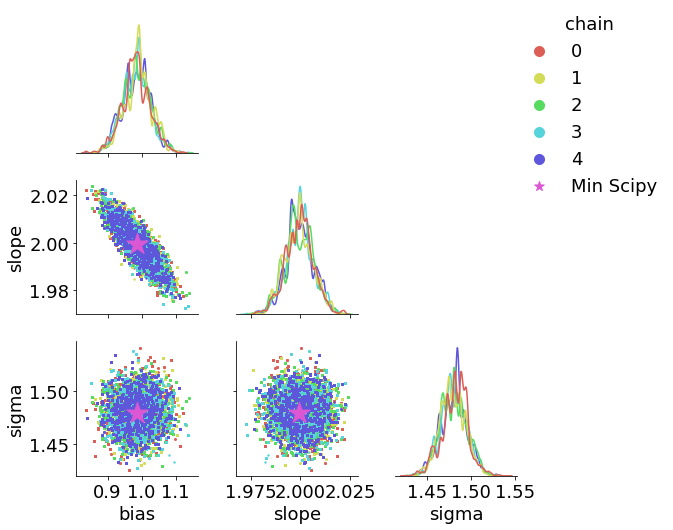

In [99]:
g = sns.PairGrid(full_df_2[full_df_2["chain"].str.fullmatch('0|1|2|3|4|Min Scipy')], 
                 diag_sharey=False,
                 hue="chain",
                 hue_kws={"s": [2]*5+[500], "marker": ["o"]*5+ ["*"]},
                 corner=True, 
                 palette="hls")
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot)
g.add_legend(loc='upper right', ncol=1)
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [100]

In [100]:
all_biass = df_res2["bias"]
all_slopes= df_res2["slope"]
all_sigmas= df_res2["sigma"]
bias_sci = lik_model['x'][0]
slope_sci  = lik_model['x'][1]
sigma_sci = lik_model['x'][2]

In [101]:
from matplotlib.gridspec import GridSpec

In [102]:
def plot_histogram_fig(ax, param, nbins):
    counts, bins = np.histogram(param, bins = nbins)
    plotcounts = np.insert(counts, -1, counts[-1])
    bincentres = (bins[:-1] + bins[1:])/2
    ax.plot(bincentres, counts, 'b')
    
def plot_contour_fig(ax, p1, p2, nbins):
    H, xedges, yedges = np.histogram2d(p1, p2, bins = nbins)
    Z = H.T
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    im = ax.contour(X, Y, Z, levels = 6)
    ax.clabel(im, inline=True, fontsize=4)

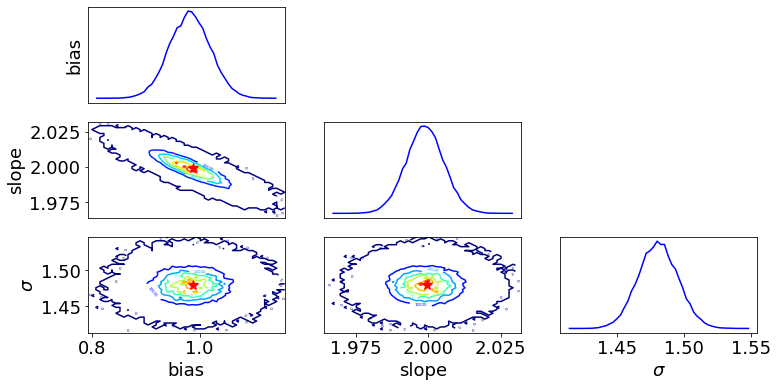

In [103]:
nbins=50
fig = plt.figure(figsize = (12, 6))
gs1 = GridSpec(3, 3, wspace=0.2)
ax00 = fig.add_subplot(gs1[0, 0])
plot_histogram_fig(ax00,all_biass, nbins)
ax00.set_xticks([])
ax00.set_yticks([])
ax00.set_ylabel('bias')

ax10 = fig.add_subplot(gs1[1, 0])
plot_contour_fig(ax10, all_biass, all_slopes, nbins)
ax10.plot(bias_sci,slope_sci,'*r',markersize=10)
ax10.set_xticks([])
ax10.set_ylabel('slope')

ax11 = fig.add_subplot(gs1[1, 1])
plot_histogram_fig(ax11,all_slopes, nbins)
ax11.set_xticks([])
ax11.set_yticks([])

ax20 = fig.add_subplot(gs1[2, 0])
plot_contour_fig(ax20, all_biass, all_sigmas, nbins)
ax20.plot(bias_sci,sigma_sci,'*r',markersize=10)
ax20.set_xlabel('bias')
ax20.set_ylabel('$\sigma$')

ax21 = fig.add_subplot(gs1[2, 1])
plot_contour_fig(ax21, all_slopes, all_sigmas, nbins)
ax21.plot(slope_sci,sigma_sci,'*r',markersize=10)
ax21.set_xlabel('slope')
ax21.set_yticks([])

ax22= fig.add_subplot(gs1[2, 2])
plot_histogram_fig(ax22,all_sigmas, nbins)
ax22.set_yticks([])
ax22.set_xlabel('$\sigma$')

plt.show()

In [104]:
df_res2.describe()

,bias,slope,sigma
count,1.000000e+07,1.000000e+07,1.000000e+07
mean,9.863464e-01,1.999543e+00,1.480337e+00
std,4.157538e-02,7.208651e-03,1.482659e-02
min,7.925474e-01,1.963870e+00,1.412753e+00
25%,9.579834e-01,1.994720e+00,1.470287e+00
50%,9.863339e-01,1.999575e+00,1.480252e+00
75%,1.014159e+00,2.004356e+00,1.490342e+00
max,1.165618e+00,2.033512e+00,1.549268e+00


## Nous verrons une autre façon d'exploiter les samples...

# Hamiltonian Monte Carlo

HMC en 180sec: on a une probabilité cible notée $p_c(x)$ que l'on essaye d'échantillonner.
$$
\Large
p_c(x) = \frac{e^{-V(x)}}{Z} \Leftrightarrow -\log(p_c(x)) = V(x) + Cte
$$
où 
$$
\Large
V(x) = -\log(\pi(x)\mathcal{L}(x|\mathcal{D}))
$$
avec $\pi(x)$ le *prior* et $\mathcal{L}$ le likelihood. La technique HMC introduit une variable conjuguée à $x$, que l'on note opportunément $p$ et l'on forme la fonction (hamiltonien) 
$$
\Large
H(x,p) = V(x) + E_c(p)
$$
avec $E_c(p)$ une pseudo-énergie cinétique (terme quadratique avec matrice de masse).
$$
\Large
\dot{x} = \frac{\partial H}{\partial p} = \frac{\partial E_c}{\partial p} = p
\qquad 
\dot{p} = -\frac{\partial H}{\partial x} = -\frac{\partial V}{\partial x} = \frac{\partial \log p_c(x)}{\partial x} 
$$

Algo:
- tirage aléatoire de $p_i\sim \mathcal{N}(0,1)$; puis l'on initialise $p_{new}=p_i$ et symétriquement $x_{new}=x_i$; 
- itération de $n_{steps}$ étapes d'intégration des équations du mouvement suivant la méthode dite de l'algorithme **leapfrog** en anglais ou **saute-mouton** en français (traduction non-littérale): 
$$
\Large
\begin{cases}
	p_{new} &= p_{new} - \varepsilon \times \frac{1}{2} \frac{\partial V(x)}{\partial x}|_{x=x_{new}}  \\
	x_{new} &= x_{new} + \varepsilon \times p_{new} \\
	p_{new} &= p_{new} - \varepsilon \times \frac{1}{2} \frac{\partial V(x)}{\partial x}|_{x=x_{new}}
	\end{cases}
$$
(notons la mise à jour du gradient en cours de route);
- puis, on renverse le moment $p_{new} = -p_{new}$;
- enfin, on procède comme pour l'algorithme de Metropolis selon la probabilité d'acceptation du nouvel état  $(x_{new},p_{new})$:
$$
\Large
p_{acc} = \mathrm{min}\left\{1,r=\frac{\tilde{P}(x_{new},p_{new})}{\tilde{P}(x_i,p_i)} \right\}
$$
avec
$$
\Large
\tilde{P}(x,y) = e^{-H(x,p)} = e^{-V(x)}\times e^{-E_c(p)}
$$
Cela se fait par tirage uniforme d'un nombre $u$ dans l'intervalle $[0,1]$. Si $u<r$ on accepte $x_{new}$ comme valeur pour $x_{i+1}$, sinon on prend $x_i$. Remarquons le découplage qu'il y a entre les deux variables $x$ et $p$. Notons aussi, que l'on ne garde pas $p_{new}$ par la suite.

**NUTS** est une évolution pour aider à déterminer le nombre de steps et la longueur du step pour l'algorithme d'intégration leapfrog.

## code simple à-la-main

In [8]:
def normal(x,mu,sigma):
    return np.exp(-neg_log_prob(x,mu,sigma))

def neg_log_prob(x,mu,sigma):
#    print(x,mu,sigma)
    tmp= 0.5*((x-mu)/sigma)**2 + 0.5*np.log(2*np.pi*sigma**2)
    return tmp

def gradV(x,mu,sigma):
    return (x-mu)/sigma**2

def HMC(mu=0.0,sigma=1.0,n_steps=10,step_size=0.25,initial_position=0.0,n_spl=10,dump=False):
    # setup
    samples = np.zeros(n_spl)
    samples[0] = initial_position
    momentum_dist = scs.norm(scale=1.0) # gaussian distribution for momentum proposal
    n_accept = 1
    # generate samples
    for i in range(1,n_spl):
        q0 = samples[i-1]
        q1 = q0
        p0 = momentum_dist.rvs()        
        p1 = p0 
        gradV0 = gradV(q0,mu,sigma) #(q0-mu)/(sigma**2) # explicit gradient

        
        # leapfrog integration begin
        for s in range(n_steps): 
            p1 -= step_size*gradV0/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1     # position increases as function of momentum 
            gradV1 = gradV(q1,mu,sigma) #(q1-mu)/(sigma**2) # update gradient
            if dump:
                print(f"[{i}/{s}] gradV0:{gradV0}, gradV1:{gradV1}")
            p1 -= step_size*gradV1/2 # second half-step "leapfrog" update to momentum    
        # leapfrog integration end        
        #### p1 = -1*p1 #flip momentum for reversibility unnecessary in practice as kinetic term is quadratic in p    

        
        #metropolis-hastings acceptance (negative log version)
        q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q1_nlp = neg_log_prob(x=q1,mu=mu,sigma=sigma)        

        p0_nlp = neg_log_prob(x=p0,mu=0.,sigma=1.)
        p1_nlp = neg_log_prob(x=p1,mu=0.,sigma=1.)
        
        target = q0_nlp - q1_nlp # P(q1)/P(q0)
        adjustment = p1_nlp - p0_nlp # P(p0)/P(p1)
        r = target + adjustment # [P(q1)*P(p0)]/[P(q0)*P(p1)] 
        
        u = np.log(scs.uniform.rvs())
            
        if dump:
            print(f"[{i}] q0:{q0},q1:{q1}")

        
        if u < r:
            samples[i]=q1
            n_accept += 1
        else:
            samples[i]=q0
    
    return samples, n_accept/n_spl

In [9]:
mu = 0
sigma = 1
Ns = 10_000
samples, acc_rate = HMC(n_steps=15,step_size=0.14, n_spl=Ns, 
                      initial_position=scs.uniform.rvs(loc=-3,scale=6),
                      mu=mu,sigma=sigma,dump=False) 
print('accept rate:',acc_rate)

accept rate: 0.6513


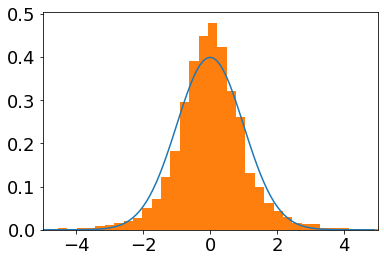

In [10]:
x = np.arange(-mu-5*sigma,mu+5*sigma,sigma/10)
plt.plot(x,normal(x,mu=mu,sigma=sigma))
plt.hist(samples,density=True,bins=50)
plt.xlim([mu-5*sigma,mu+5*sigma])
plt.show()

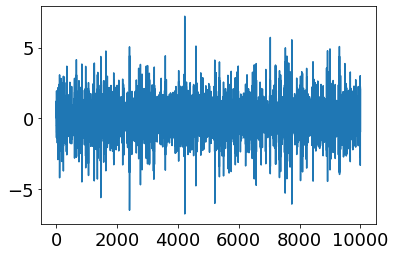

In [11]:
plt.plot(samples)

In [12]:
az.summary(samples)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.01,1.062,-2.048,2.002,0.007,0.017,16222.0,4277.0,NaN


## Apparamement le sampling est bcq plus efficace. Le pb est la sensibilité aux paramètres `n_steps=15,step_size=0.14`. Changez les pour vous faire une idée...

# NumPyro Lib.

In [13]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import HMC, MCMC, init_to_sample

## Simple gaussian dist.

In [112]:
class MixtureModel_jax():
    """
    gaussian mixture
    """
    def __init__(self, locs, scales, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loc = jnp.array([locs]).T
        self.scale = jnp.array([scales]).T
        self.weights = jnp.array([weights]).T
        norm = jnp.sum(self.weights)
        self.weights = self.weights/norm

        self.num_distr = len(locs)

    def logpdf(self, x):
        log_probs = jax.scipy.stats.norm.logpdf(x,loc=self.loc, scale=self.scale)
        return jax.scipy.special.logsumexp(jnp.log(self.weights) + log_probs, axis=0)[0]

    def pdf(self, x):
        probs = jax.scipy.stats.norm.pdf(x,loc=self.loc, scale=self.scale)
        return jnp.dot(self.weights.T,probs).squeeze()

In [46]:
def phi(x):
    return x**2

In [47]:
single_gaussian_model = MixtureModel_jax([0],[1],[1])

In [48]:
Integ_true,_=sc_integrate.quad(lambda x: phi(x)*single_gaussian_model.pdf(x),-7,7)

In [49]:
print("Integ. true: ",Integ_true)

Integ. true:  0.9999999998695543


In [50]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = HMC(potential_fn=lambda x: -single_gaussian_model.logpdf(x))  # negative log
num_samples = 1_000_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False) # progress_bar=True ralentit bcq... donc ok pour num_samples=1000.
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_1 = mcmc.get_samples()

/sps/lsst/users/campagne/anaconda3/envs/JaxTutos/lib/python3.8/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -0.00      1.00     -0.00     -1.65      1.64 219315.47      1.00

Number of divergences: 0


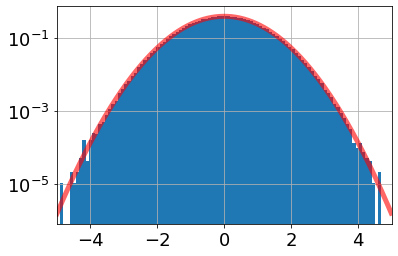

In [51]:
fig = plt.figure()
x_axis = np.arange(-5, 5, 0.01)
#mixture_pdf = jax.vmap(mixture_gaussian_model.pdf)(x_axis)
plt.hist(np.array(samples_1.squeeze()), bins=100, density=True);
plt.plot(x_axis, single_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.xlim([-5,5])
plt.yscale('log')
plt.grid()
plt.show()

In [52]:
phi_spl1 = phi(samples_1)
Integ_HMC1 = np.mean(phi_spl1)
print(f"Integ_HMC:{Integ_HMC1:.6e}, err. relat: {np.abs(Integ_HMC1-Integ_true)/Integ_true:.6e}, sample size : {len(samples_1.flatten())}")

Integ_HMC:9.977529e-01, err. relat: 2.247060e-03, sample size : 1000000


In [55]:
az.ess(np.array(samples_1.squeeze()), relative=True)

0.21931631741854699

## On a une bonne efficacité de sampling ($22\%$) sur ce cas simple  qui rend compte de l'err. relative.

## Mixture of gaussian dist.

In [56]:
mixture_gaussian_model = MixtureModel_jax([0,1.5],[0.5,0.1],[8,2])

In [57]:
Integ_true,_=sc_integrate.quad(lambda x: phi(x)*mixture_gaussian_model.pdf(x),-7,7)

In [58]:
print("Integ. true: ",Integ_true)

Integ. true:  0.652


In [108]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = HMC(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x),
            trajectory_length=1.0)  # negative log
num_samples = 1_000_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_1 = mcmc.get_samples()

/sps/lsst/users/campagne/anaconda3/envs/JaxTutos/lib/python3.8/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.30      0.75      0.16     -0.63      1.64  28707.19      1.00

Number of divergences: 0


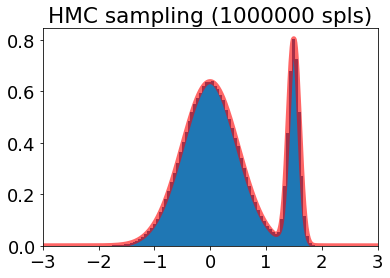

In [109]:
fig = plt.figure()
x_axis = np.arange(-3, 3, 0.01)
#mixture_pdf = jax.vmap(mixture_gaussian_model.pdf)(x_axis)
plt.hist(np.array(samples_1.squeeze()), bins=100, density=True);
plt.plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.xlim([-3,3])
plt.title(f"HMC sampling ({len(samples_1.flatten())} spls)")
plt.show()

In [110]:
phi_spl1 = phi(samples_1)
Integ_HMC1 = np.mean(phi_spl1)
print(f"Integ_HMC:{Integ_HMC1:.6e}, err. relat: {np.abs(Integ_HMC1-Integ_true)/Integ_true:.6e}, sample size : {len(samples_1.flatten())}")

Integ_HMC:6.555026e-01, err. relat: 5.372124e-03, sample size : 1000000


In [111]:
az.ess(np.array(samples_1.squeeze()), relative=True)

0.03852060519618474

## Moins bonne efficacité de sampling ($3.8\%$) sur ce cas avec pic secondaire. Même si HMC est un progrès par rapport à M-H (rappel: eff. de $0.1\%$) on peut trouver mieux comme méthode.

## Exo: Changer la valeur `trajectory_length=1.0` par exemple `0.5,1.5,2*jnp.pi (default), ...)`. Notez la sensibilité des résultats en termes d'efficacité d'échantillonnage et donc d'erreur relative sur le calcul de l'intégrale.



# Takeaway message:
- Si en `1D` on peut calculer des intégrales avec des quadratures (Simpson, Trapèzes, Gauss, Clenshaw-Curtis, etc.) en dimension quelconque on ne peut que procéder des méthodes Monte Carlo d'échantillonnage. On calcule alors des moyennes pondérées.
- Dans un premier temps nous avons vu `l'Importance Sampling` en utilisant une pdf auxilaire $q(x)$ qui approxime $p(x)$. Mais ceci ne marche bien que si $q(x)$ est une "bonne " approximtion de $p(x)$ et cela est requis d'autant plus que la dimension $d$ du problème augmente.
- En adaptant au coup par coup $q(x)$, on a aboutit à la méthode de `Metropolis-Hastings`. Mais celle-ci bien que souvent employée a une efficacité d'échantillonnage de $0.1\%$ même sur des cas pas trop pathologiques en 1D. Cela est du au caractère de `marche aléatoire` de la méthode.
- Une dernière méthode prometteuse vue dans ce nb est celle à base d'équations différentuielles de Hamilton (Hamiltionian Monte carlo, aka HMC). Certes on augmente l'efficacité d'échantillonnage d'un facteur 10, mais il faut bien choisir les paramètres de l'algorithme `leapfrog` (`nombre de steps, et longueur de chaque step`).

# Extra 
Après avoir vu le notebook `JAX-NUTS-regression-piecewise`: au lieu de HMC, on peu utiliser NUTS. Reprendre l'exemple du mélange de 2 gaussiennes et voir ce que cela donne en termes d'efficacité d'échantillonnage.